# Chest X-ray pathology classification

The idea of this notebook is to try to create a model for predicting only certain types of pathologies from NIH chest x-ray images. As can be seen from this (https://www.kaggle.com/sbernadac/lung-deseases-data-analysis) fine kernel, most of the pathologies in the data set are related and tend to co-occur with other medical conditions. The purpose was to make a classifier which could successfully classify those pathologies which usually aren't present at the same time and treating others only as "symptoms" or predictive features. Some ideas were also borrowed from:  https://www.kaggle.com/kmader/train-simple-xray-cnn

In [1]:

import numpy as np 
import pandas as pd 
import matplotlib.pylab as plt
import seaborn as sns
import cv2
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D
from keras.layers import MaxPool2D, MaxPooling2D, GlobalAveragePooling2D, SeparableConv2D
from keras.applications.vgg16 import VGG16
import tensorflow as tf

from glob import glob
import os
%matplotlib inline


Using TensorFlow backend.


In [2]:
# Set seeds
np.random.seed(999)
tf.random.set_seed(1999)

# Load entry data
BBox_List = pd.read_csv("../input/data/BBox_List_2017.csv")
Data_Entry = pd.read_csv("../input/data/Data_Entry_2017.csv")

print(os.listdir("../input/data/"))
print()
print("Image indices in data entry: {}".format(len(Data_Entry["Image Index"])))

Data_Entry = Data_Entry.set_index("Image Index")
Data_Entry.head()

['images_008', 'images_011', 'images_007', 'test_list.txt', 'images_004', 'images_012', 'train_val_list.txt', 'images_002', 'Data_Entry_2017.csv', 'images_010', 'images_006', 'LOG_CHESTXRAY.pdf', 'BBox_List_2017.csv', 'FAQ_CHESTXRAY.pdf', 'images_009', 'README_CHESTXRAY.pdf', 'ARXIV_V5_CHESTXRAY.pdf', 'images_003', 'images_005', 'images_001']

Image indices in data entry: 112120


,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
Image Index,,,,,,,,,,,
00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [3]:
# Map the image paths onto xray_data
# Credit: https://www.kaggle.com/kmader/train-simple-xray-cnn

image_paths = {os.path.basename(x): x for x in glob('../input/data/images*/images/*.png')}
Data_Entry['path'] = Data_Entry.index.map(image_paths.get)

Number of unique labels: 836


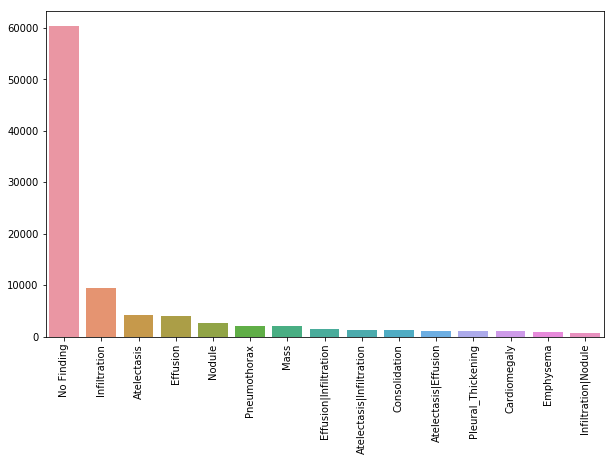

In [4]:
# Let's examine the distribution of findings
unique_labels = Data_Entry["Finding Labels"].unique()
print("Number of unique labels: {}".format(len(unique_labels)))

label_counts = Data_Entry["Finding Labels"].value_counts()
#print(label_counts)

# Bar plot the most frequent finding labels
fig = plt.figure(figsize=(10,6))
bp = sns.barplot(label_counts.index[:15], label_counts.values[:15])

# Rotate labels and suppress output
_ = bp.set_xticklabels(label_counts.index, rotation=90)

In [5]:
# The idea is to try to classify only non-related conditions from the 
# images ignoring the probable secondary conditions

# Let's filter the data so that only images with one of the chosen conditions 
# is present in each image in the used dataset

conditions = ["No Finding","Cardiomegaly", "Emphysema", "Fibrosis", "Nodule", "Pneumonia"]

def filter_conditions(df, conditions, x):
    filtered = df[df["Finding Labels"].str.contains(x)]
    
    other_conditions = list(conditions)
    other_conditions.remove(x)
    
    for cond in other_conditions:
        remove = filtered[filtered["Finding Labels"].str.contains(cond, regex=True)]
        filtered = filtered.drop(remove.index)
    return filtered

data_filtered = pd.DataFrame()
for x in conditions:
    data_filtered = data_filtered.append(filter_conditions(Data_Entry, conditions, x))

# Since a great majority of the data has "No Finding" label, let's balance the dataset by sampling out  
# a large fraction of the class

no_finding_frac = data_filtered[data_filtered["Finding Labels"]=="No Finding"].sample(frac=0.9, replace=False).index
data_filtered = data_filtered.drop(no_finding_frac)
print("Size of dataset: {}".format(len(data_filtered)))
data_filtered.head(10)


Size of dataset: 19495


,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
Image Index,,,,,,,,,,,,
00000011_002.png,No Finding,2,11,75,M,PA,2714,2781,0.143000,0.143000,NaN,../input/data/images_001/images/00000011_002.png
00000013_000.png,No Finding,0,13,61,M,PA,2021,2021,0.194311,0.194311,NaN,../input/data/images_001/images/00000013_000.png
00000017_002.png,No Finding,2,17,78,M,AP,2500,2048,0.168000,0.168000,NaN,../input/data/images_001/images/00000017_002.png
00000018_000.png,No Finding,0,18,75,M,PA,2500,2048,0.168000,0.168000,NaN,../input/data/images_001/images/00000018_000.png
00000032_008.png,No Finding,8,32,55,F,AP,2500,2048,0.168000,0.168000,NaN,../input/data/images_001/images/00000032_008.png
00000039_001.png,No Finding,1,39,75,M,PA,2992,2991,0.143000,0.143000,NaN,../input/data/images_001/images/00000039_001.png
00000052_001.png,No Finding,1,52,64,M,PA,2992,2991,0.143000,0.143000,NaN,../input/data/images_001/images/00000052_001.png
00000054_005.png,No Finding,5,54,64,F,PA,2826,2991,0.143000,0.143000,NaN,../input/data/images_001/images/00000054_005.png
00000055_000.png,No Finding,0,55,81,F,PA,2048,2500,0.171000,0.171000,NaN,../input/data/images_001/images/00000055_000.png


In [6]:
# Adding target labels for the examined conditions
data_dummies = data_filtered["Finding Labels"].str.get_dummies("|")

#data_filtered["target"] = data_dummies[conditions].values.tolist()
#for cond in conditions:
#    data_filtered[cond] = data_filtered["Finding Labels"].map(lambda labels : cond in labels )
#data_filtered["target"] = data_filtered["target"].map(np.array)

data_filtered["target"] = data_dummies[conditions].idxmax(axis=1)
print(data_filtered["target"].value_counts())
data_filtered.sample(10)

No Finding      6036
Nodule          5888
Cardiomegaly    2540
Emphysema       2305
Fibrosis        1435
Pneumonia       1291
Name: target, dtype: int64


,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path,target
Image Index,,,,,,,,,,,,,
00022070_004.png,Atelectasis|Effusion|Pneumonia,4,22070,12,M,PA,2350,2465,0.143000,0.143000,NaN,../input/data/images_010/images/00022070_004.png,Pneumonia
00014022_010.png,Effusion|Pneumonia,10,14022,65,M,AP,2500,2048,0.168000,0.168000,NaN,../input/data/images_007/images/00014022_010.png,Pneumonia
00001029_015.png,Fibrosis,15,1029,23,M,PA,2762,2669,0.143000,0.143000,NaN,../input/data/images_001/images/00001029_015.png,Fibrosis
00000997_001.png,Fibrosis,1,997,32,M,PA,2500,2048,0.171000,0.171000,NaN,../input/data/images_001/images/00000997_001.png,Fibrosis
00007046_003.png,Emphysema,3,7046,42,M,AP,2500,2048,0.171000,0.171000,NaN,../input/data/images_004/images/00007046_003.png,Emphysema
00014706_015.png,No Finding,15,14706,21,F,AP,2500,2048,0.168000,0.168000,NaN,../input/data/images_007/images/00014706_015.png,No Finding
00013209_002.png,Emphysema|Pneumothorax,2,13209,74,F,AP,2500,2048,0.168000,0.168000,NaN,../input/data/images_006/images/00013209_002.png,Emphysema
00028940_005.png,Infiltration|Pneumonia,5,28940,64,M,PA,2021,2011,0.194311,0.194311,NaN,../input/data/images_012/images/00028940_005.png,Pneumonia
00021895_007.png,Cardiomegaly,7,21895,32,M,PA,2992,2991,0.143000,0.143000,NaN,../input/data/images_010/images/00021895_007.png,Cardiomegaly


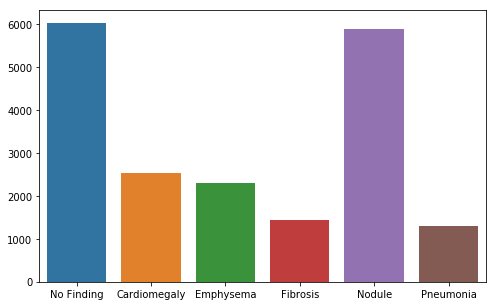

In [7]:
# Plot data distribution
fig = plt.figure(figsize=(8,5))
sns.barplot(conditions, data_dummies[conditions].sum())

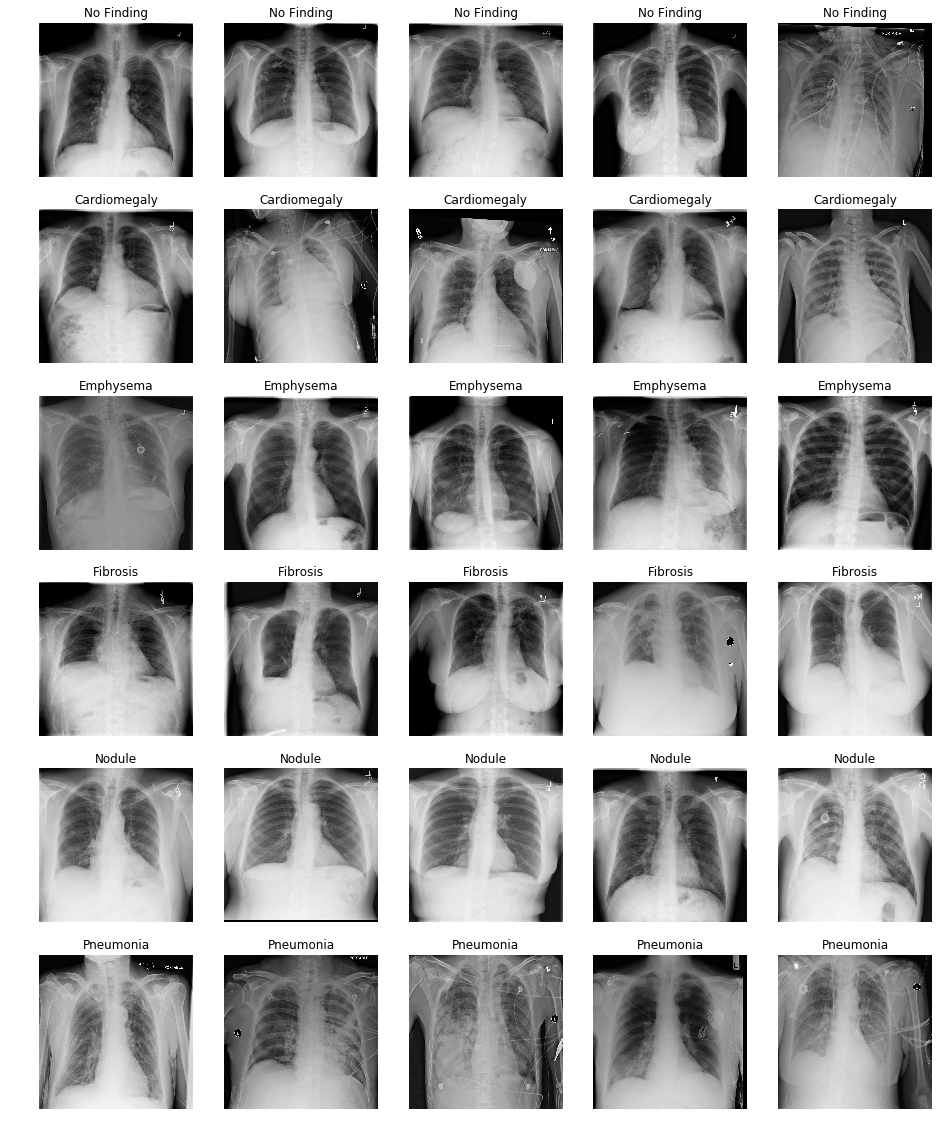

In [8]:
# Show a few sample images of conditions

def plot_samples(condition, n_samples, ax):
    img = data_filtered[data_filtered["target"]==condition].sample(n_samples, random_state=1111).index
    image_paths = list(data_filtered.loc[img, "path"])
    for i,axis in enumerate(ax):
        image = cv2.imread(image_paths[i])
        axis.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axis.axis('off')
        axis.set_title(condition)

n = len(conditions)
fig, ax = plt.subplots(n, 5, figsize=(16,20))

for j,cond in enumerate(conditions):
    plot_samples(cond, 5, ax[j,:])

In [9]:
train_data, test_data = train_test_split(data_filtered, test_size=0.25, random_state=3030)
test_data, validation_data = train_test_split(test_data, test_size=0.5, random_state=2020)
train_data.head()
print("number of samples in training set: {}".format(len(train_data)))
print("number of samples in validation set: {}".format(len(validation_data)))
print("number of samples in test set: {}".format(len(test_data)))

number of samples in training set: 14621
number of samples in validation set: 2437
number of samples in test set: 2437


In [10]:
# Creating generator for data

train_data_gen = ImageDataGenerator(
        rescale=1.0/255.0,
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True)

test_data_gen = ImageDataGenerator(rescale=1.0/255.0)
batch_size = 64

# Use the path variable as filename since it already contains the full path
train_generator = train_data_gen.flow_from_dataframe(
        train_data,
        x_col="path",
        y_col = "target",
        class_mode = "categorical",
        seed = 1,
        color_mode = 'rgb',
        batch_size = batch_size,
        target_size = (224,224)
        )

validation_generator = test_data_gen.flow_from_dataframe(
        validation_data,
        x_col="path",
        y_col = "target",
        class_mode = "categorical",
        color_mode = 'rgb',
        target_size = (224,224),
        batch_size = 256
        )

test_generator = test_data_gen.flow_from_dataframe(
        test_data,
        x_col="path",
        y_col = "target",
        class_mode = "categorical",
        color_mode = 'rgb',
        target_size = (224,224),
        batch_size = 64,
        shuffle=False
        )

Found 14621 validated image filenames belonging to 6 classes.
Found 2437 validated image filenames belonging to 6 classes.
Found 2437 validated image filenames belonging to 6 classes.


(224, 224, 3)


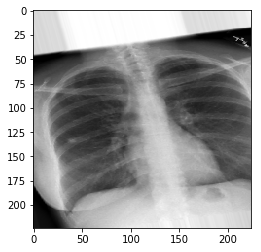

In [11]:
# Plotting a sample image from the training generator

train_x, train_y = next(train_generator)
print(train_x[0].shape)
fig = plt.figure()
plt.imshow(cv2.cvtColor(train_x[0], cv2.COLOR_BGR2RGB))


In [12]:
print(os.listdir("../input"))
base_model = VGG16(include_top=False, weights=None, input_shape=(224,224,3))
print(base_model.summary())

['data', 'chest-x-ray-pathologies-predict', 'keras-pretrained-models']
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
________________________________________________________

In [13]:
# Adding some layers to the pretrained vgg16

base_model.load_weights("../input/keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5")
base_model.trainable = True
x = base_model.output
x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='block6_conv1')(x)
x = BatchNormalization()(x)
x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='block6_conv2')(x)
x = BatchNormalization()(x)
x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='block6_conv3')(x)

#x = GlobalAveragePooling2D()(x)
x = MaxPooling2D((2,2), name='block6_pool1')(x)
x = Flatten(name='flatten')(x)
x = Dense(1024, activation='relu', name='dense_1')(x)
x = Dropout(0.5, name='dropout_1')(x)
x = Dense(512, activation='relu', name='dense_2')(x)
x = Dropout(0.2, name='dropout_2')(x)
prediction = Dense(6, activation='softmax', name='output_1')(x)

model = Model(inputs=base_model.input, outputs=prediction)

# For fixing the pretrained parameters
#print(len(model.layers))
#for layer in model.layers[:10]:
#    layer.trainable = False
    
# Playing around with different learing rate and decay
lr = 0.0001
n_epochs = 40

opt = Adam(lr=lr, decay=1e-5)

model.compile(loss='categorical_crossentropy', 
                  optimizer=opt, 
                  metrics=['accuracy'])

print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [14]:
early_stop = EarlyStopping(patience=10)
checkpoint = ModelCheckpoint(filepath='current_best_model', save_best_only=True)

# Define the number of training steps
n_train_steps = train_data.shape[0]//batch_size
n_validation_steps = validation_data.shape[0]//batch_size

print("Number of training steps: {} ".format(n_train_steps))


Number of training steps: 228 


In [15]:
history = model.fit_generator(train_generator, epochs=n_epochs, steps_per_epoch=n_train_steps,
                              validation_data=validation_generator,
                              validation_steps = n_validation_steps,
                              callbacks=[early_stop, checkpoint])

Epoch 1/40
228/228 [==============================] - 572s 3s/step - loss: 1.6112 - accuracy: 0.3040 - val_loss: 1.6976 - val_accuracy: 0.3369
Epoch 2/40
228/228 [==============================] - 518s 2s/step - loss: 1.5810 - accuracy: 0.3257 - val_loss: 1.6251 - val_accuracy: 0.3572
Epoch 3/40
228/228 [==============================] - 520s 2s/step - loss: 1.5712 - accuracy: 0.3305 - val_loss: 1.5876 - val_accuracy: 0.3028
Epoch 4/40
228/228 [==============================] - 510s 2s/step - loss: 1.5642 - accuracy: 0.3319 - val_loss: 1.6540 - val_accuracy: 0.2848
Epoch 5/40
228/228 [==============================] - 506s 2s/step - loss: 1.5512 - accuracy: 0.3510 - val_loss: 1.5906 - val_accuracy: 0.3233
Epoch 6/40
228/228 [==============================] - 508s 2s/step - loss: 1.5290 - accuracy: 0.3745 - val_loss: 1.5507 - val_accuracy: 0.3917
Epoch 7/40
228/228 [==============================] - 511s 2s/step - loss: 1.4920 - accuracy: 0.4010 - val_loss: 1.4923 - val_accuracy: 0.3553

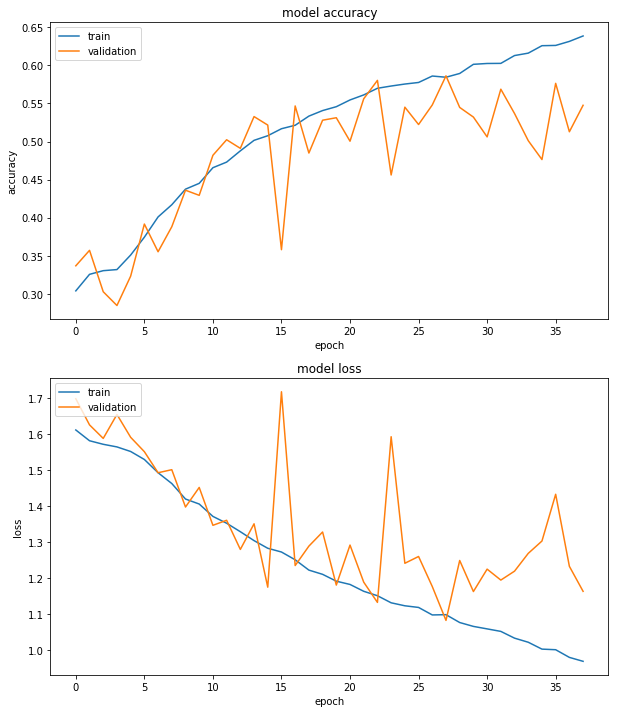

In [16]:

fig, axes = plt.subplots(2,1, figsize=(10,12))
measures = ["accuracy", "loss"]
for i,ax in enumerate(axes):
    ax.plot(history.history[measures[i]])
    ax.plot(history.history['val_' + measures[i]])
    ax.set_title('model ' + measures[i])
    ax.set_ylabel(measures[i])
    ax.set_xlabel('epoch')
    ax.legend(['train', 'validation'], loc='upper left')

In [17]:
model.load_weights("../input/chest-x-ray-pathologies-predict/current_best_model")

In [18]:
predicted = model.predict(test_generator,steps=len(test_generator), verbose = True)

39/39 [==============================] - 53s 1s/step


In [19]:
test_generator.reset()
targets = test_data["target"].unique()
targets.sort()
print(test_data["target"].value_counts())
print(targets)
print()

print(predicted[0:5])
print()

# Predicted classes as integers and One hot encoded
pred_Y_as_int = np.argmax(predicted, axis=1)
n_classes = np.max(pred_Y_as_int)+1
pred_Y = np.eye(n_classes)[pred_Y_as_int]
print(pred_Y[0:5])
print()

# Same for true labels
test_Y_as_int = test_generator.labels
n_test = np.max(test_Y_as_int)+1
test_Y = np.eye(n_test)[test_Y_as_int]
print(test_Y[0:5])
test_data.head()


Nodule          756
No Finding      743
Cardiomegaly    299
Emphysema       285
Fibrosis        188
Pneumonia       166
Name: target, dtype: int64
['Cardiomegaly' 'Emphysema' 'Fibrosis' 'No Finding' 'Nodule' 'Pneumonia']

[[2.1101035e-01 2.8205156e-02 1.3199164e-01 3.6388314e-01 2.0372452e-01
  6.1185222e-02]
 [9.0136188e-01 1.3631616e-03 2.7644935e-03 7.1317770e-02 1.0970054e-02
  1.2222723e-02]
 [3.2113228e-02 1.7931581e-02 1.1492680e-01 1.1446593e-01 5.9167057e-01
  1.2889197e-01]
 [1.3434804e-02 5.3726020e-03 3.5639521e-02 5.9292376e-01 3.0559269e-01
  4.7036696e-02]
 [4.1260724e-03 6.2779186e-04 2.2342433e-03 9.3605912e-01 4.9518179e-02
  7.4346797e-03]]

[[0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]]

[[0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0.]]


,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path,target
Image Index,,,,,,,,,,,,,
00013858_005.png,Infiltration|Nodule,5,13858,62,M,PA,2992,2991,0.143,0.143,NaN,../input/data/images_007/images/00013858_005.png,Nodule
00021481_003.png,Cardiomegaly|Edema|Infiltration,3,21481,63,M,AP,3056,2544,0.139,0.139,NaN,../input/data/images_010/images/00021481_003.png,Cardiomegaly
00021086_008.png,Consolidation|Effusion|Nodule,8,21086,62,M,PA,2992,2991,0.143,0.143,NaN,../input/data/images_010/images/00021086_008.png,Nodule
00023412_000.png,Nodule,0,23412,29,M,PA,2500,2048,0.168,0.168,NaN,../input/data/images_010/images/00023412_000.png,Nodule
00011734_000.png,No Finding,0,11734,36,M,AP,2500,2048,0.168,0.168,NaN,../input/data/images_006/images/00011734_000.png,No Finding


Accuracy score: 0.5789905621665983


Text(0, 0.5, 'True Positive Rate')

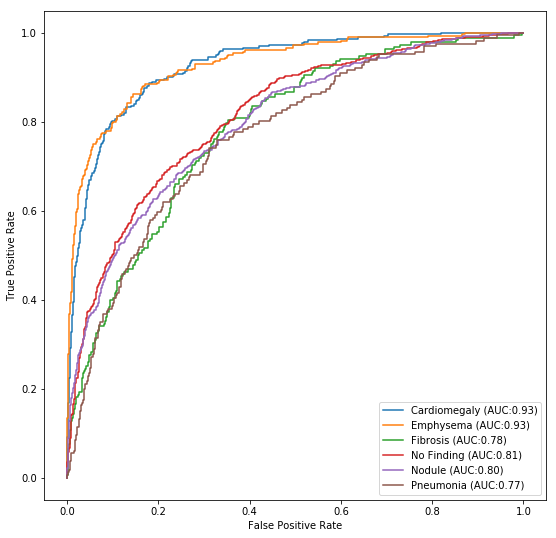

In [20]:
score = accuracy_score(test_Y, pred_Y)
print("Accuracy score: {}".format(score))

fig, ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, target) in enumerate(targets):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx], predicted[:,idx])
    ax.plot(fpr, tpr, label = "{0:s} (AUC:{1:.2f})".format(target, auc(fpr, tpr)))

ax.legend()
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

([<matplotlib.axis.YTick at 0x7fbe58ef0630>,
 <a list of 6 Text yticklabel objects>)

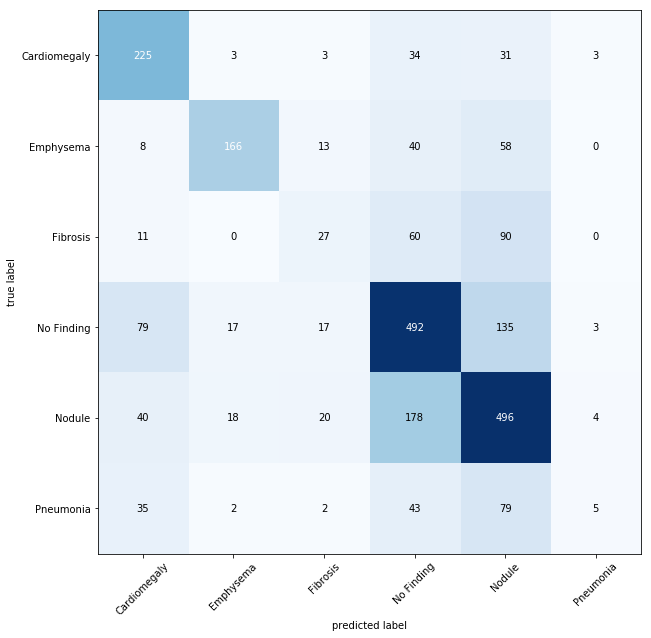

In [21]:
from mlxtend.plotting import plot_confusion_matrix
plot_confusion_matrix(confusion_matrix(test_Y_as_int, pred_Y_as_int), figsize=(10,10))
plt.xticks(range(len(targets)), targets, fontsize=10, rotation=45)
plt.yticks(range(len(targets)), targets, fontsize=10)